<a href="https://colab.research.google.com/github/steppenhj/Everything/blob/main/Assignment1_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# 1. 꼬인 폴더가 있다면 삭제 (깨끗한 상태로 시작)
if os.path.exists('/content/cub200'):
    !rm -rf /content/cub200
    print("기존 폴더 삭제 완료.")

# 2. 캐글 인증 정보 다시 입력 (런타임 끊겼을 수 있으므로 안전하게)
# (아까 혜진님이 주신 토큰 정보 그대로입니다)
os.environ['KAGGLE_USERNAME'] = "parkhaejin11111"
os.environ['KAGGLE_KEY'] = "KGAT_9a18dce92a644299734b8d3bac273a02"

# 3. 로컬 경로(/content)에서 바로 다운로드
# (구글 드라이브를 거치지 않아서 훨씬 빠르고 안정적입니다)
os.chdir('/content')
print("데이터 다운로드 시작 (로컬)...")
!kaggle datasets download -d wenewone/cub2002011

# 4. 압축 해제
print("압축 해제 중...")
!unzip -q cub2002011.zip -d ./cub200

# 5. [중요] 진짜 경로 찾기
# 압축이 풀린 뒤 'images' 폴더가 어디 숨어있는지 파이썬이 직접 찾게 합니다.
print("폴더 위치 찾는 중...")
found_path = ""
for root, dirs, files in os.walk("/content/cub200"):
    if "images" in dirs:
        found_path = os.path.join(root, "images")
        break

if found_path:
    print(f"✅ 찾았다! 진짜 이미지 경로: {found_path}")
else:
    print("❌ 오류: images 폴더를 찾을 수 없습니다.")

데이터 다운로드 시작 (로컬)...
Dataset URL: https://www.kaggle.com/datasets/wenewone/cub2002011
License(s): CC0-1.0
100% 1.49G/1.49G [00:13<00:00, 80.6MB/s]
100% 1.49G/1.49G [00:13<00:00, 118MB/s] 
압축 해제 중...
폴더 위치 찾는 중...
✅ 찾았다! 진짜 이미지 경로: /content/cub200/CUB_200_2011/images


In [ ]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# 1. 경로 설정 (아까 확인한 로컬 경로)
data_dir = '/content/cub200/CUB_200_2011/images'
print(f"학습 데이터 경로 확인: {data_dir}")

# 2. 전처리(Transform) 설정
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. 데이터셋 불러오기
# 경로에 폴더가 실제로 있는지 확인 후 로드
if os.path.exists(data_dir):
    full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    print(f"✅ 데이터 로드 성공! 총 이미지: {len(full_dataset)}장")

    # 4. 학습용(80%) / 테스트용(20%) 분리
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # 5. 로더 생성 (배치 사이즈 32)
    # num_workers=2는 코랩에서 데이터 로딩 속도를 높여줍니다.
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print("🎉 데이터 로더 준비 완료! 이제 다음 셀(학습 코드)을 실행하세요.")

else:
    print(f"❌ 오류: 경로에 폴더가 없습니다. {data_dir}를 확인해주세요.")

학습 데이터 경로 확인: /content/cub200/CUB_200_2011/images
✅ 데이터 로드 성공! 총 이미지: 11796장
🎉 데이터 로더 준비 완료! 이제 다음 셀(학습 코드)을 실행하세요.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 1. GPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"현재 학습 장치: {device}")

# 2. ResNet50 모델 불러오기 (Pretrained)
model = models.resnet50(pretrained=True)

# ----------------------------------------------------------
# [핵심 변경점] 모델의 파라미터(지식)를 얼립니다(Freeze).
# 이렇게 하면 기존에 이미지넷에서 배운 똑똑한 지식이 유지됩니다.
for param in model.parameters():
    param.requires_grad = False
# ----------------------------------------------------------

# 3. 출력층 수정 (여기는 새로 만들었으므로 자동으로 학습이 됩니다)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 200) # 200개 클래스
model = model.to(device)

# 4. 학습 설정 (Optimizer가 'model.fc' 즉, 마지막 층만 건드리도록 설정)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# 5. 학습 루프 (5 Epoch)
num_epochs = 5
print(f"🚀 성능 개선된 학습 시작! (총 {num_epochs} Epoch)")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # 순전파 & 역전파
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 통계
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    epoch_acc = 100 * correct / total
    print(f"✨ Epoch {epoch+1} 종료 | 평균 Loss: {running_loss/len(train_loader):.4f} | 정확도: {epoch_acc:.2f}%")

print("🏆 학습 완료!")

현재 학습 장치: cuda
🚀 성능 개선된 학습 시작! (총 5 Epoch)
Epoch [1/5] Step [50/295] Loss: 4.9375
Epoch [1/5] Step [100/295] Loss: 3.5961
Epoch [1/5] Step [150/295] Loss: 2.8081
Epoch [1/5] Step [200/295] Loss: 3.2626
Epoch [1/5] Step [250/295] Loss: 2.9467
✨ Epoch 1 종료 | 평균 Loss: 3.7228 | 정확도: 23.37%
Epoch [2/5] Step [50/295] Loss: 2.2796
Epoch [2/5] Step [100/295] Loss: 1.7517
Epoch [2/5] Step [150/295] Loss: 1.6823
Epoch [2/5] Step [200/295] Loss: 1.9599
Epoch [2/5] Step [250/295] Loss: 1.5959
✨ Epoch 2 종료 | 평균 Loss: 1.8818 | 정확도: 54.73%
Epoch [3/5] Step [50/295] Loss: 1.7089
Epoch [3/5] Step [100/295] Loss: 1.3476
Epoch [3/5] Step [150/295] Loss: 1.1976
Epoch [3/5] Step [200/295] Loss: 1.1996
Epoch [3/5] Step [250/295] Loss: 1.4221
✨ Epoch 3 종료 | 평균 Loss: 1.3789 | 정확도: 64.67%
Epoch [4/5] Step [50/295] Loss: 0.8535
Epoch [4/5] Step [100/295] Loss: 1.0942
Epoch [4/5] Step [150/295] Loss: 1.0346
Epoch [4/5] Step [200/295] Loss: 0.5844
Epoch [4/5] Step [250/295] Loss: 1.3228
✨ Epoch 4 종료 | 평균 Loss: 1.

In [ ]:
# --- Fine-tuning (성능 부스팅) ---
print("🔥 성능을 극한으로 올리기 위해 '모든 층'을 학습합니다 (Fine-tuning)")

# 1. 모델의 모든 층을 '학습 가능' 상태로 변경 (Unfreeze)
for param in model.parameters():
    param.requires_grad = True

# 2. 학습률(Learning Rate)을 1/10로 줄임
# (이미 학습된 지식이 망가지지 않도록 살살 튜닝하기 위함)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 3. 추가 학습 진행 (3 Epoch만 더!)
fine_tune_epochs = 3
print(f"🚀 추가 학습 시작! (총 {fine_tune_epochs} Epoch)")

for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 50 == 0:
             print(f"Fine-tuning Epoch [{epoch+1}/{fine_tune_epochs}] Step [{i+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    epoch_acc = 100 * correct / total
    print(f"✨ 추가 학습 {epoch+1}회차 완료 | 평균 Loss: {running_loss/len(train_loader):.4f} | 정확도: {epoch_acc:.2f}%")

print("🏆 최종 학습 완료! 이제 평가를 진행하세요.")

🔥 성능을 극한으로 올리기 위해 '모든 층'을 학습합니다 (Fine-tuning)
🚀 추가 학습 시작! (총 3 Epoch)
Fine-tuning Epoch [1/3] Step [50/295] Loss: 0.7259
Fine-tuning Epoch [1/3] Step [100/295] Loss: 0.9926
Fine-tuning Epoch [1/3] Step [150/295] Loss: 0.3767
Fine-tuning Epoch [1/3] Step [200/295] Loss: 0.8783
Fine-tuning Epoch [1/3] Step [250/295] Loss: 0.7217
✨ 추가 학습 1회차 완료 | 평균 Loss: 0.7758 | 정확도: 78.31%
Fine-tuning Epoch [2/3] Step [50/295] Loss: 0.4569
Fine-tuning Epoch [2/3] Step [100/295] Loss: 0.1229
Fine-tuning Epoch [2/3] Step [150/295] Loss: 0.2077
Fine-tuning Epoch [2/3] Step [200/295] Loss: 0.0712
Fine-tuning Epoch [2/3] Step [250/295] Loss: 0.1025
✨ 추가 학습 2회차 완료 | 평균 Loss: 0.1539 | 정확도: 97.03%
Fine-tuning Epoch [3/3] Step [50/295] Loss: 0.0374
Fine-tuning Epoch [3/3] Step [100/295] Loss: 0.0338
Fine-tuning Epoch [3/3] Step [150/295] Loss: 0.0608
Fine-tuning Epoch [3/3] Step [200/295] Loss: 0.0248
Fine-tuning Epoch [3/3] Step [250/295] Loss: 0.0231
✨ 추가 학습 3회차 완료 | 평균 Loss: 0.0337 | 정확도: 99.87%
🏆 최종 학습 완료! 

📝 최종 Test 데이터셋으로 채점 중...
🎉 최종 Test 정확도: 75.04%
📊 혼동 행렬(Confusion Matrix) 생성 중...


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


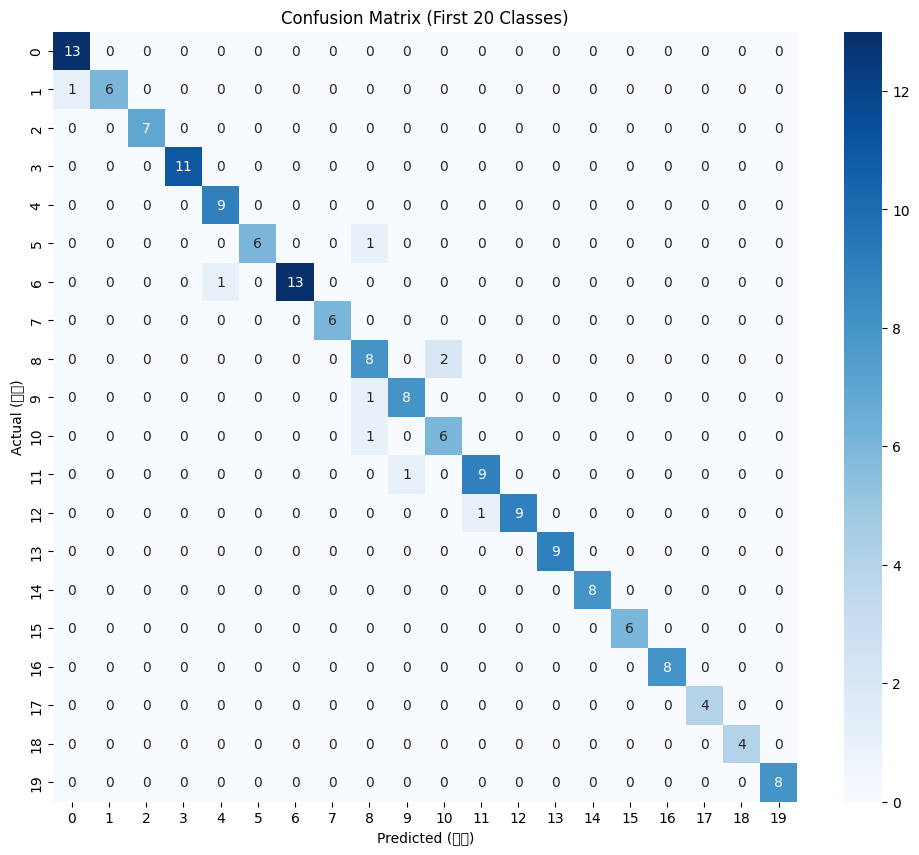

In [ ]:
# --- 과제 1번 최종 제출용 코드 ---
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np

# 1. 평가 함수 (Test Set 정확도 측정)
def final_evaluate(model, loader):
    model.eval() # 평가 모드
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    print("📝 최종 Test 데이터셋으로 채점 중...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * correct / total
    print(f"🎉 최종 Test 정확도: {acc:.2f}%")
    return all_labels, all_preds

# 2. 평가 실행
labels, preds = final_evaluate(model, test_loader)

# 3. 혼동 행렬 시각화 (보고서용)
# 200개를 다 그리면 너무 복잡하므로, 상위 20개 클래스만 시각화합니다.
print("📊 혼동 행렬(Confusion Matrix) 생성 중...")
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm[:20, :20])

plt.figure(figsize=(12, 10))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (First 20 Classes)")
plt.ylabel('Actual (정답)')
plt.xlabel('Predicted (예측)')
plt.show()

In [ ]:
# Grad-CAM 라이브러리 설치
!pip install grad-cam
print("설치 완료!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=c2f1746290ec50961179e582bcef2c578a6542ad5336ef36946a72a99204eb40
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam
설치 완료!


📸 Grad-CAM 시각화 결과 생성 중... (보고서에 이 그림들을 넣으세요)


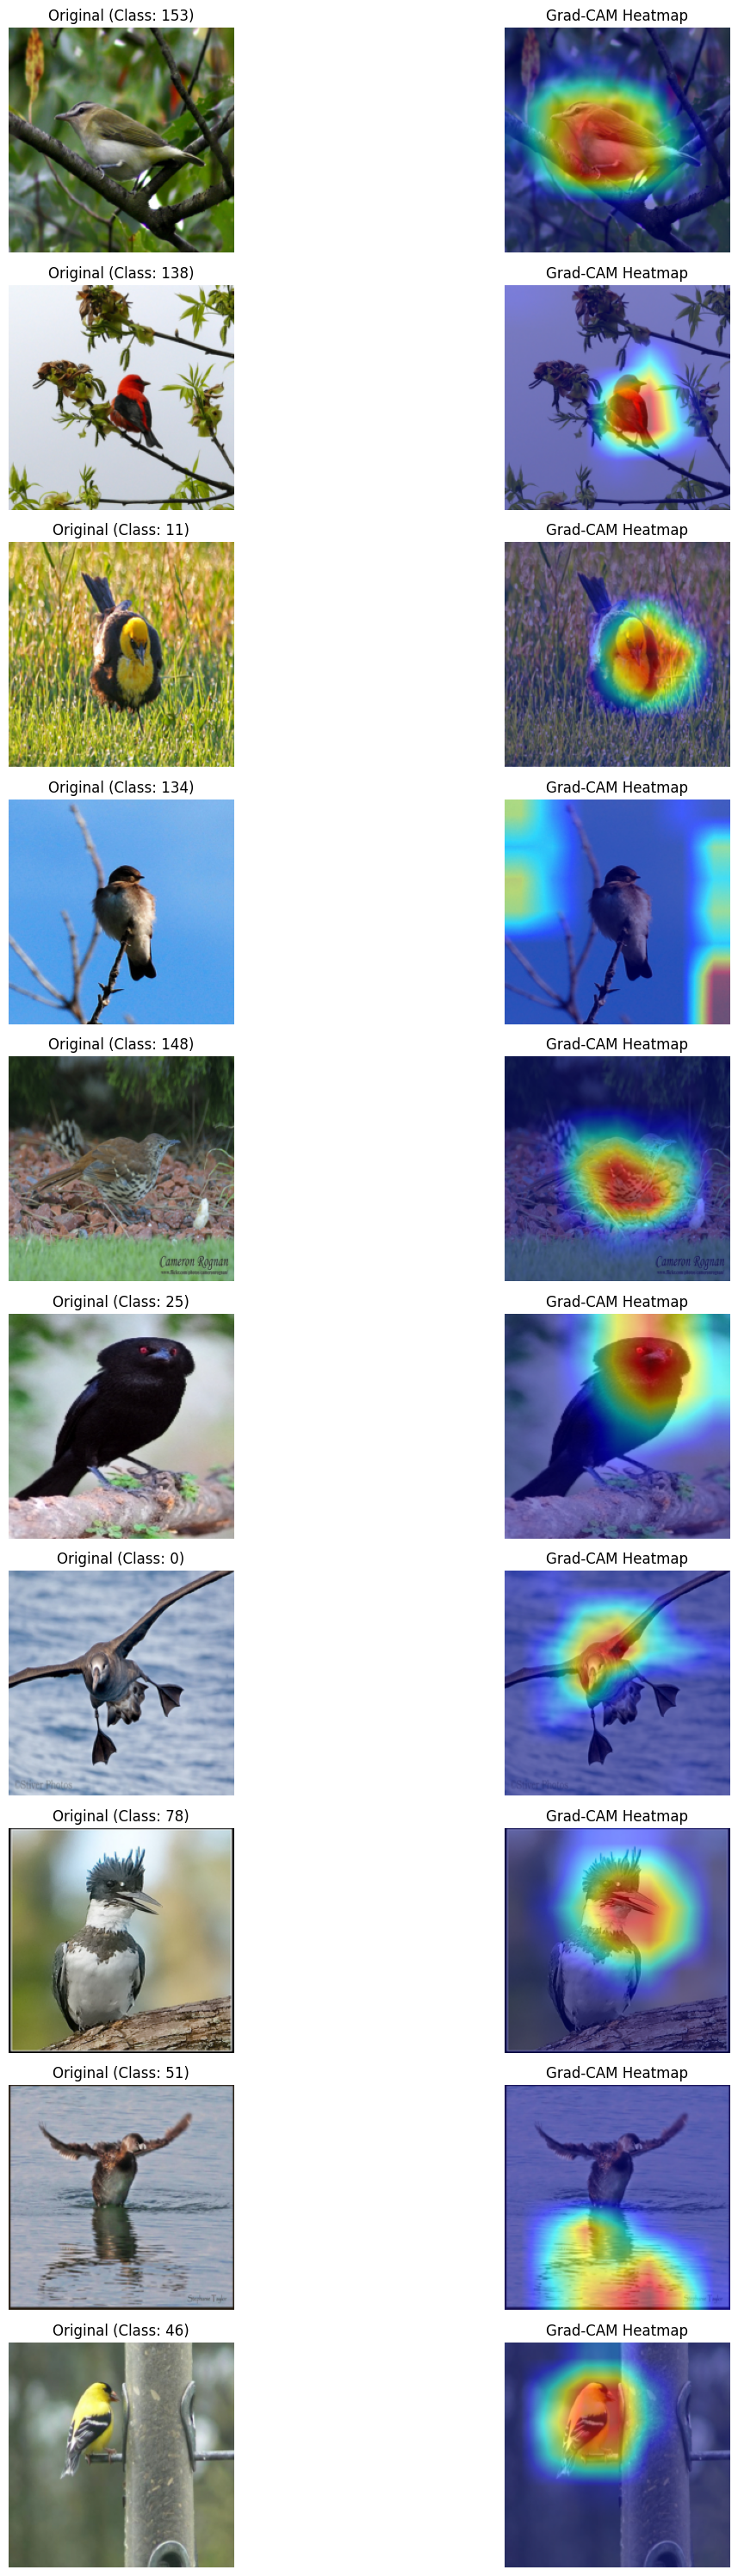

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import cv2
import random

# 1. Grad-CAM을 적용할 레이어 선택
# ResNet50의 경우, 가장 마지막 합성곱 층인 'layer4의 마지막 블록'을 주로 봅니다.
target_layers = [model.layer4[-1]]

# 2. Grad-CAM 객체 생성
cam = GradCAM(model=model, target_layers=target_layers)

# 3. 시각화 함수 정의
def visualize_gradcam(model, loader, num_images=10):
    model.eval()

    # Test 데이터셋에서 랜덤으로 샘플 추출
    # dataset은 (이미지텐서, 라벨인덱스) 튜플로 되어 있음
    indices = random.sample(range(len(loader.dataset)), num_images)

    plt.figure(figsize=(15, num_images * 3))

    for idx, sample_idx in enumerate(indices):
        img_tensor, label_idx = loader.dataset[sample_idx]

        # (1) 입력 전처리: 4차원 배치 형태로 변환 (1, 3, 224, 224)
        input_tensor = img_tensor.unsqueeze(0).to(device)

        # (2) Grad-CAM 히트맵 생성
        # targets=None이면 모델이 예측한 가장 높은 점수의 클래스를 기준으로 봄
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :] # 첫 번째 배치의 결과만 가져옴

        # (3) 원본 이미지 복원 (시각화를 위해 정규화 해제)
        # 텐서(GPU) -> 넘파이(CPU) -> (C, H, W) -> (H, W, C)
        rgb_img = img_tensor.cpu().numpy().transpose(1, 2, 0)

        # 정규화(Normalize) 했던 것을 역으로 돌림 (Mean, Std 이용)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        rgb_img = std * rgb_img + mean
        rgb_img = np.clip(rgb_img, 0, 1) # 0~1 사이로 자름

        # (4) 이미지 위에 히트맵 덧씌우기
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # (5) 출력 (좌: 원본, 우: Grad-CAM 결과)
        plt.subplot(num_images, 2, 2*idx + 1)
        plt.imshow(rgb_img)
        plt.title(f"Original (Class: {label_idx})")
        plt.axis('off')

        plt.subplot(num_images, 2, 2*idx + 2)
        plt.imshow(visualization)
        plt.title("Grad-CAM Heatmap")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 4. 실행 (이미지 10장 시각화)
print("📸 Grad-CAM 시각화 결과 생성 중... (보고서에 이 그림들을 넣으세요)")
visualize_gradcam(model, test_loader, num_images=10)

In [ ]:
import torch
import numpy as np
import cv2

# 1. IoU(Intersection over Union) 계산 함수
# 두 개의 네모 박스가 얼마나 겹치는지 0~1 사이 숫자로 알려줍니다.
def calculate_iou(boxA, boxB):
    # box = [x_min, y_min, x_max, y_max]

    # 겹치는 영역(Intersection) 좌표 계산
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # 겹치는 넓이
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # 각 박스의 넓이
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # 합집합 넓이(Union)
    unionArea = boxAArea + boxBArea - interArea

    # IoU 계산
    if unionArea == 0: return 0
    iou = interArea / unionArea
    return iou

# 2. Grad-CAM 히트맵에서 박스(Bbox) 추출하는 함수
# "상위 20% 이상 Activation 영역"을 기준으로 박스를 만듭니다.
def get_gradcam_bbox(heatmap, threshold=0.2):
    # 히트맵 정규화 (0~1)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    # 임계값(Threshold) 적용: 상위 20% (0.2) 이상인 부분만 1로 만듦 (Binary Mask)
    mask = np.where(heatmap > threshold, 1, 0).astype(np.uint8)

    # 마스크에서 외곽선(Contour) 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return [0, 0, 0, 0] # 영역 없음

    # 가장 큰 영역을 선택해서 박스로 만듦
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    return [x, y, x+w, y+h] # [x_min, y_min, x_max, y_max]

print("준비 완료! 계산 도구들을 만들었습니다.")

준비 완료! 계산 도구들을 만들었습니다.


📸 수정된 IoU 분석 시작! (이번엔 빨간 박스가 나올 겁니다)


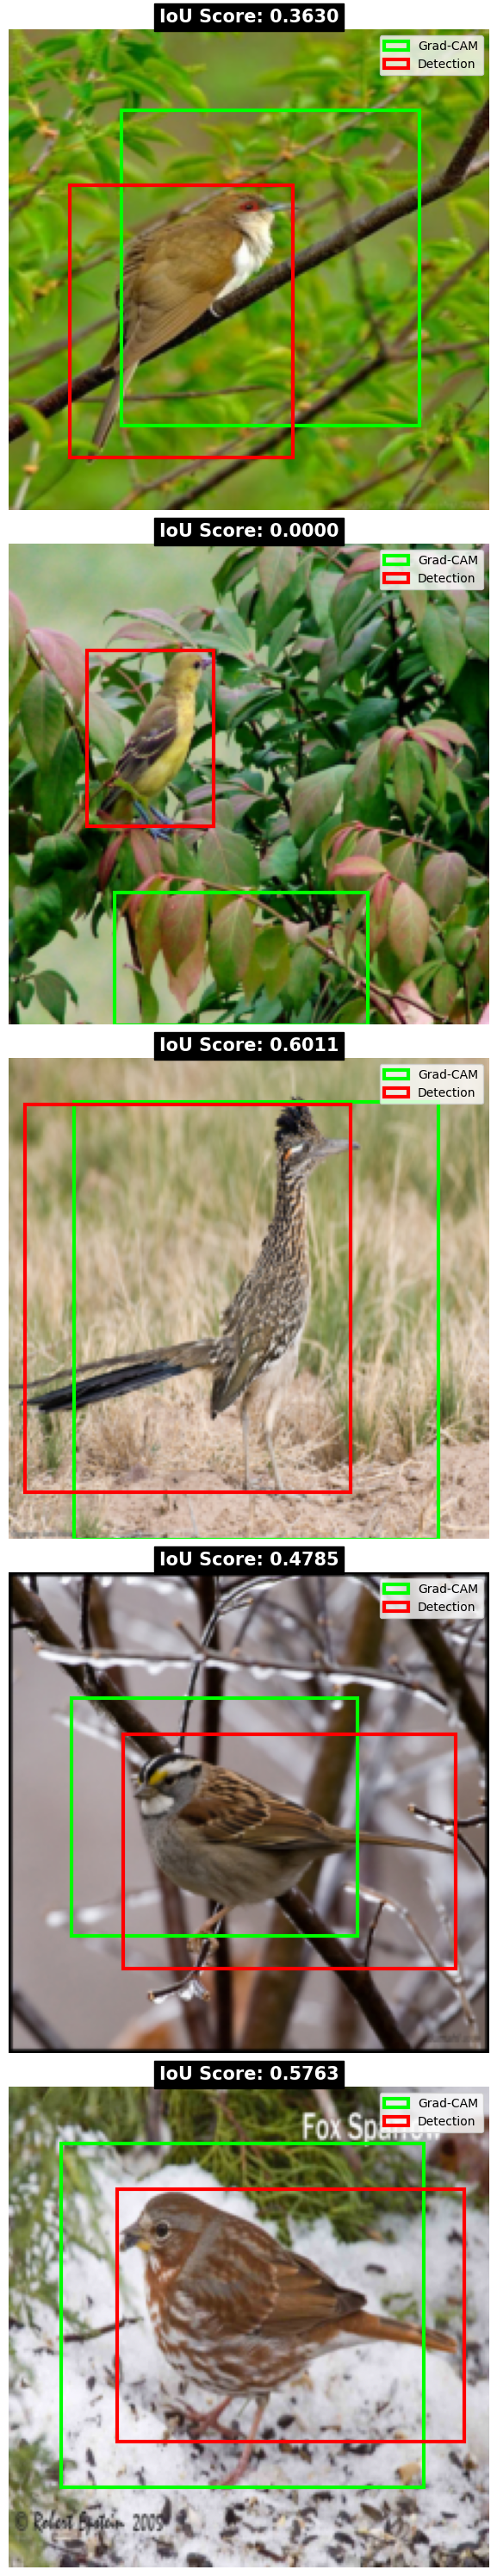

In [ ]:
import torch
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# 1. 모델 준비 (아까와 동일)
detection_model = fasterrcnn_resnet50_fpn(pretrained=True)
detection_model.eval()
detection_model = detection_model.to(device)

# 2. 정규화를 풀어주는 함수 (NEW!)
def inverse_normalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    return tensor * std + mean

# 3. 시각화 및 IoU 계산 함수 (수정됨)
def visualize_iou_fixed(model, det_model, loader, num_images=5):
    # Test 셋에서 랜덤 추출
    indices = random.sample(range(len(loader.dataset)), num_images)

    plt.figure(figsize=(12, 6 * num_images))

    for idx, sample_idx in enumerate(indices):
        img_tensor, label_idx = loader.dataset[sample_idx]
        img_tensor = img_tensor.to(device)

        # (1) Grad-CAM용 입력 (정규화된 상태 그대로)
        input_tensor_cam = img_tensor.unsqueeze(0)

        # (2) Detection용 입력 (정규화를 풀어서 원본처럼 만듦) -> 핵심 수정 사항!
        input_tensor_det = inverse_normalize(img_tensor).unsqueeze(0)
        # 값이 0~1 범위를 벗어날 수 있으므로 클리핑
        input_tensor_det = torch.clamp(input_tensor_det, 0, 1)

        # --- A. Grad-CAM 박스 구하기 ---
        grayscale_cam = cam(input_tensor=input_tensor_cam, targets=None)[0, :]
        cam_bbox = get_gradcam_bbox(grayscale_cam, threshold=0.2)

        # --- B. Detection 박스 구하기 ---
        with torch.no_grad():
            det_outputs = det_model(input_tensor_det)

        # 결과 필터링
        pred_boxes = det_outputs[0]['boxes'].cpu().numpy()
        pred_labels = det_outputs[0]['labels'].cpu().numpy()
        pred_scores = det_outputs[0]['scores'].cpu().numpy()

        det_bbox = [0, 0, 0, 0]
        found_bird = False

        # 점수 기준을 0.3으로 조금 낮춰서 더 잘 찾게 함
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            if label == 16 and score > 0.3:
                det_bbox = box.astype(int)
                found_bird = True
                break

        # --- C. IoU 계산 ---
        iou_score = calculate_iou(cam_bbox, det_bbox)

        # --- D. 시각화 ---
        # 원본 이미지(numpy) 변환
        rgb_img = input_tensor_det.squeeze().cpu().numpy().transpose(1, 2, 0)

        ax = plt.subplot(num_images, 1, idx + 1)
        ax.imshow(rgb_img)

        # Grad-CAM 박스 (초록)
        rect_cam = patches.Rectangle((cam_bbox[0], cam_bbox[1]),
                                     cam_bbox[2]-cam_bbox[0], cam_bbox[3]-cam_bbox[1],
                                     linewidth=3, edgecolor='lime', facecolor='none', label='Grad-CAM')
        ax.add_patch(rect_cam)

        # Detection 박스 (빨강)
        if found_bird:
            rect_det = patches.Rectangle((det_bbox[0], det_bbox[1]),
                                         det_bbox[2]-det_bbox[0], det_bbox[3]-det_bbox[1],
                                         linewidth=3, edgecolor='red', facecolor='none', label='Detection')
            ax.add_patch(rect_det)
            title_text = f"IoU Score: {iou_score:.4f}"
        else:
            title_text = "Detection Failed"

        plt.title(title_text, fontsize=15, fontweight='bold', color='white', backgroundcolor='black')
        plt.legend(loc='upper right')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("📸 수정된 IoU 분석 시작! (이번엔 빨간 박스가 나올 겁니다)")
visualize_iou_fixed(model, detection_model, test_loader, num_images=5)